## Implementation of the deep conditional measure quantization (DCMQ) algorithm

---
This implements the DCMQ algorithm introduced by G. Turinici 2023.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli 
from scipy.special import softmax as scipy_softmax
import pandas as pd
from tqdm import tqdm

In [2]:
K=10#number of Dirac masses in the compressed distribution
N=2#ambient dimension
parameter_dim=2#the dimension of the parameter 
J=1024#batch size / how many samples are included in a batch in order to compute the good statistical distance: more the better, otherwise there are oscillations in the SGD/Adam convergence
parameter_batch_size=16#how many parameters to optimize simultaneously

quant=tf.Variable(np.random.rand(N,K),dtype=tf.float32)#this will be the set of quantization variables

#Define empirical sampling

In [3]:
def parameter_sampling(batch_size=parameter_batch_size):
  ''' Returns a set of parameters as 2D array; attention'''
  return np.random.randn(batch_size,parameter_dim)

def empirical_sampling_conditional_2D_gaussian_mean(sampleN=N,sampleJ=J,parameter=np.zeros((parameter_batch_size,parameter_dim))):
    ''' sample from the normal law in dimension N of mean = parameter and variance identity

    The output is of size parameter_batch_size x sampleN x sampleJ
    The parameter is mentionned in the 'parameter' input; it is a 2D array.
    '''    
    assert(sampleN==2), "invalid dimension in 2D conditional sampling"
    return np.random.randn(parameter_batch_size,sampleN,sampleJ)+ parameter[:,:,None]

def empirical_sampling_conditional_2D_gaussian_variance(sampleN=N,sampleJ=J,parameter=np.zeros((parameter_batch_size,parameter_dim))):
    ''' sample from the normal law in dimension N of mean = parameter and variance identity

    The output is of size parameter_batch_size x sampleN x sampleJ
    The parameter is mentionned in the 'parameter' input; it is a 2D array.
    '''    
    assert(sampleN==2), "invalid dimension in 2D conditional sampling"
    return np.random.randn(parameter_batch_size,sampleN,sampleJ)*parameter[:,:,None]

In [48]:
empirical_sampling=empirical_sampling_conditional_2D_gaussian_variance
case_label="std_"

In [35]:
empirical_sampling=empirical_sampling_conditional_2D_gaussian_mean
case_label="mean_"

In [53]:
print("case label : ",case_label)
#test empirical sampling
empirical_sampling(parameter=parameter_sampling()).shape

case label :  std_


(16, 2, 1024)

#Empirical Radon Sobolev distance

In [5]:
def empirical_radon_sobolev_distance_sq(X,Y,local_alphas=None,betas=None):
    '''
    Parameters
    ----------
    X : 2D NxK matrix
        input data sample, each column a vector of dimension N, notation X_k
    Y : same as X for the second distribution
    alphas : 1D array of weights for X
    betas : same as alphas for Y 

    Note: X,alphas are Tensor/Variable while Y/betas are numpy array

    Returns
    -------
    Radon-Sobolev distance
    
    '''
    N,K=X.shape
    Ny,J=Y.shape
    Ytensor = tf.convert_to_tensor(Y, dtype=tf.float32)

    if local_alphas is None:
      alphas = tf.convert_to_tensor(np.ones(K)/K,dtype=tf.float32)
    else:
      alphas=tf.nn.softmax(local_alphas)
    if betas is None:
        betas = np.ones(J)/J
    betastensor = tf.convert_to_tensor(betas.astype(np.float32), dtype=tf.float32)
    
    assert (tf.rank(X).numpy()==2) & (Y.ndim==2) & (tf.rank(alphas).numpy()==1) & (betas.ndim==1),"invalid input dimensions"
    Ka,=alphas.shape
    Jb,=betas.shape
    assert (N==Ny)& (K==Ka)&(J==Jb), 'invalid input dimensions'
    #construct big matrix
    points=tf.concat([X,Ytensor],axis=1)
    gammas=tf.concat([alphas,-betastensor],axis=0)
    #construct the distances matrix as a K+J x K+J matrix
    distZZ = tf.math.sqrt(1.0e-10+tf.math.reduce_sum(tf.square(tf.expand_dims(points,2)-tf.expand_dims(points,1)),axis=0))-1.0e-5
    return tf.squeeze(-0.5*tf.expand_dims(gammas,0)@distZZ@tf.expand_dims(gammas,1))

#debug and tests
print(empirical_radon_sobolev_distance_sq(tf.ones([N,K]),tf.zeros([N,J])))
print(empirical_radon_sobolev_distance_sq( tf.convert_to_tensor( np.array([[-1,1],[-1,1]]), dtype=tf.float32),
                                          np.array([[-1,-1,1,1],[-1,1,-1,1]])))

tf.Tensor(1.4142293, shape=(), dtype=float32)
tf.Tensor(0.14644536, shape=(), dtype=float32)


In [6]:
#debug and tests
np.array([[-1,1],[-1,1]])
np.array([[-1,-1,1,1],[-1,1,-1,1]])
tf.convert_to_tensor( np.array([[-1,1],[-1,1]]), dtype=tf.float32)
tf.convert_to_tensor(np.array([[-1,-1,1,1],[-1,1,-1,1]]), dtype=tf.float32)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-1., -1.,  1.,  1.],
       [-1.,  1., -1.,  1.]], dtype=float32)>

##Construction of the network

The network takes as input a 1D set of parameters and outputs the $N\times K$ quantization points.

The network architecture is the following: several FC layers with 'relu' activation and size $N \times K$. Then a final dense layer of output size $N\times K$ with no activation. This layer is used for computing the statistical distance to be minimized.


In [7]:
if(False):#logarithmic increase in layer size
  nb_layers=5#number of layers
  layers_dim=[int(np.ceil(a)) for a in 
  np.exp(np.linspace(np.log(parameter_dim),np.log(N*K),nb_layers,endpoint=True))]

  dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu,input_shape=(2,))
  dense2 = tf.keras.layers.Dense(7, activation=tf.nn.relu,input_shape=(4,))
  dense3 = tf.keras.layers.Dense(12, activation=tf.nn.relu,input_shape=(7,))
  dense4 = tf.keras.layers.Dense(20, activation=tf.nn.relu,input_shape=(12,))
  dense_final = tf.keras.layers.Dense(20,input_shape=(20,))

if(True):#several FC layers of N*K size
  dense1 = tf.keras.layers.Dense(N*K, activation=tf.nn.relu,input_shape=(parameter_dim,))
  dense2 = tf.keras.layers.Dense(N*K, activation=tf.nn.relu,input_shape=(N*K,))
  dense3 = tf.keras.layers.Dense(N*K, activation=tf.nn.relu,input_shape=(N*K,))
  dense4 = tf.keras.layers.Dense(N*K, activation=tf.nn.relu,input_shape=(N*K,))
  dense_final = tf.keras.layers.Dense(N*K,input_shape=(N*K,))

final_reshape = tf.keras.layers.Reshape((N,K),input_shape=(N*K,))

In [8]:
#a list of trainable layers to be used later
trainable_layers=[dense1,dense2,dense3,dense4,dense_final]

In [37]:
def quantization_proposal(parameter):
  ''' traverse the network once for a parameter'''
  x1 = dense1(parameter)#attention this has a parameter_batch_size inside
  x2 = dense2(x1)
  x3 = dense3(x2)
  x4 = dense4(x3)
  xfinal = dense_final(x4)
  return final_reshape(xfinal)

In [9]:
#redefine the distance to take only one argument: a tuple
def empirical_radon_sobolev_distance_sq_one_argument(input):
  return  empirical_radon_sobolev_distance_sq(input[0],input[1])

def quantization_loss(training=True):
  parameter = parameter_sampling()
  xfinal_reshaped=quantization_proposal(parameter)
#  print(xfinal_reshaped.shape,xfinal_reshaped.dtype,
#        empirical_sampling(parameter=parameter).astype(np.float32).dtype)
#  return None
#  return empirical_radon_sobolev_distance_sq(xfinal_reshaped[23,:,:],empirical_sampling(parameter=parameter)[23,:,:])
  loss_value=tf.reduce_mean(tf.map_fn(empirical_radon_sobolev_distance_sq_one_argument,
                elems=(xfinal_reshaped,empirical_sampling(parameter=parameter).astype(np.float32)  ),fn_output_signature=tf.float32))
##  loss_value=tf.reduce_mean(tf.vectorized_map(empirical_radon_sobolev_distance_sq_one_argument,
##                elems=(xfinal_reshaped,empirical_sampling(parameter=parameter).astype(np.float32) )))
#  print('loss value=',loss_value.numpy())
  return loss_value


In [10]:
#recall empirical_sampling returns parameter_batch_size x N x K tensor
#empirical_sampling(parameter=parameter_sampling()).shape

#testing call function
#parameter_sampling().shape
print(quantization_proposal(parameter_sampling()).shape)

#testing loss function
quantization_loss()

(16, 2, 10)


<tf.Tensor: shape=(), dtype=float32, numpy=0.2787047>

In [11]:
opt = tf.keras.optimizers.Adam()

nr_iter=1000
loss_val=[]
opt_val=[]
iter_val=[]
for sc in tqdm(range(nr_iter)):
  step_count = opt.minimize(quantization_loss, [l.variables for l in trainable_layers ]).numpy()

#  opt_val.append(quant.numpy())
#  loss_val.append(loss_quant().numpy())
  if( (sc==0) or ((sc+1) % 50 ==0) or (sc==nr_iter-1)):
    c_loss=quantization_loss().numpy()
    loss_val.append(c_loss)
    iter_val.append(sc)
    print('iteration no=',sc,' loss=',c_loss)

  0%|          | 1/1000 [00:01<27:57,  1.68s/it]

iteration no= 0  loss= 0.2755903


  5%|▌         | 50/1000 [00:42<09:23,  1.69it/s]

iteration no= 49  loss= 0.06070713


 10%|█         | 100/1000 [01:11<09:07,  1.64it/s]

iteration no= 99  loss= 0.03673327


 15%|█▌        | 150/1000 [01:40<08:34,  1.65it/s]

iteration no= 149  loss= 0.031273


 20%|██        | 200/1000 [02:11<14:18,  1.07s/it]

iteration no= 199  loss= 0.02653464


 25%|██▌       | 250/1000 [02:41<08:09,  1.53it/s]

iteration no= 249  loss= 0.022522468


 30%|███       | 300/1000 [03:10<07:44,  1.51it/s]

iteration no= 299  loss= 0.016661912


 35%|███▌      | 350/1000 [03:39<09:25,  1.15it/s]

iteration no= 349  loss= 0.012465395


 40%|████      | 400/1000 [04:08<06:04,  1.65it/s]

iteration no= 399  loss= 0.01556116


 45%|████▌     | 450/1000 [04:38<06:11,  1.48it/s]

iteration no= 449  loss= 0.015906136


 50%|█████     | 500/1000 [05:09<06:26,  1.29it/s]

iteration no= 499  loss= 0.011025322


 55%|█████▌    | 550/1000 [05:38<04:36,  1.63it/s]

iteration no= 549  loss= 0.013636436


 60%|██████    | 600/1000 [06:05<03:57,  1.68it/s]

iteration no= 599  loss= 0.012050545


 65%|██████▌   | 650/1000 [06:33<03:37,  1.61it/s]

iteration no= 649  loss= 0.010196671


 70%|███████   | 700/1000 [07:01<03:15,  1.53it/s]

iteration no= 699  loss= 0.011109276


 75%|███████▌  | 750/1000 [07:31<02:48,  1.48it/s]

iteration no= 749  loss= 0.010995147


 80%|████████  | 800/1000 [07:59<02:11,  1.52it/s]

iteration no= 799  loss= 0.010356999


 85%|████████▌ | 850/1000 [08:28<01:36,  1.55it/s]

iteration no= 849  loss= 0.0136820795


 90%|█████████ | 900/1000 [08:58<01:38,  1.01it/s]

iteration no= 899  loss= 0.010215459


 95%|█████████▌| 950/1000 [09:38<00:31,  1.60it/s]

iteration no= 949  loss= 0.012380582


100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]

iteration no= 999  loss= 0.009582847


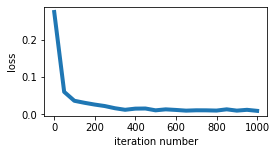

In [12]:
plt.figure("convergence",figsize=(4,2))
plt.plot(iter_val,loss_val,linewidth=4)
#df = pd.Series(loss_val)
#plt.semilogy(iter_val,np.array(df.ewm(span=10).mean()),linewidth=4)
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.savefig(case_label+'convergence.pdf')

In [13]:
#backup layers
save_filename=case_label+'layers_backup_N'+str(N)+'_K'+str(K)
print('saving to filename=',save_filename)
np.savez(save_filename,layers_data=np.array([l.variables for l in trainable_layers],dtype=object))

saving to filename= std_layers_backup_N2_K10


In [49]:
#restore layers
restore_filename=case_label+'layers_backup_N'+str(N)+'_K'+str(K)
if(True):
  print('restoring from ',restore_filename)
  loaded_data=np.load(restore_filename+".npz",allow_pickle=True)
  print(len(loaded_data['layers_data'][1]))
  #use "layer.set_weights([weights,bias])" to set weights
  #print(len(loaded_data['layers_data']))
  for l,lw in zip(trainable_layers,loaded_data['layers_data']):
    l.set_weights(lw)
  #to test:
  #print(dense2.get_weights()[0][3,5],loaded_data['layers_data'][1][0][3,5])

restoring from  std_layers_backup_N2_K10
2


parameter shape= (5, 2) quantization_cv shape= (5, 2, 10)
saving data= std_first_example


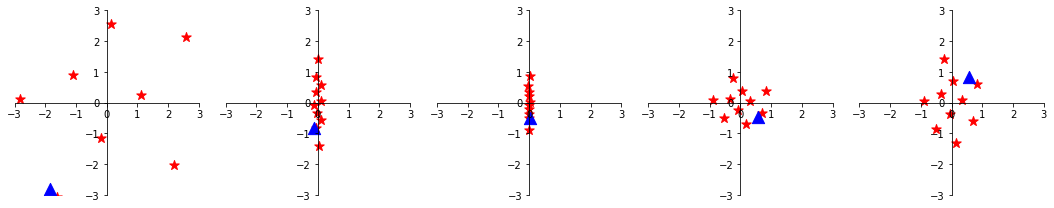

In [50]:
if(True):
  nb_plots=5

  parameter = np.sort(parameter_sampling(batch_size=nb_plots),axis=0)
  quantization_cv=quantization_proposal(parameter)
  print('parameter shape=',parameter.shape,'quantization_cv shape=',quantization_cv.shape)

  save_filename1 = case_label+'first_example'
  print('saving data=',save_filename1)
  np.savez(save_filename1,parameter=parameter,quantization_cv=quantization_cv)

  plt.figure('several_quantizations',figsize=(3*nb_plots,3) )

  for ii in range(nb_plots):

    #only plot the middle one
    ax=plt.subplot(1,nb_plots,1+ii)
    plt.scatter(quantization_cv[ii,0,:],quantization_cv[ii,1,:],c='red', marker='*',s=100)
    plt.scatter(parameter[ii,0],parameter[ii,1],c='blue',marker='^',s=150)
    # set the x-spine/ axis
    ax.spines['left'].set_position('zero')
    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    #ax.yaxis.tick_left()
    # set the y-spine/ axis
    ax.spines['bottom'].set_position('zero')
    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
    ax.set_aspect(1.)
    plt.xlim([-3,3])
    plt.ylim([-3,3])    
    plt.tight_layout()
  plt.savefig(case_label+'several_quantizations'+str(K)+'.pdf')

parameter= (100, 2)
(100, 2, 10)
saving data= std_second_example


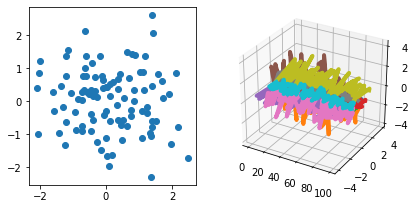

In [51]:
#colors = ['b','g','r','c','m','y']
nb_param=100
#several parameters
#parameter = np.sort(parameter_sampling(batch_size=nb_param),axis=0)
parameter = parameter_sampling(batch_size=nb_param)

print('parameter=',parameter.shape)
quantization_cv=quantization_proposal(parameter)
print(quantization_cv.shape)
save_filename2 = case_label+'second_example'
print('saving data=',save_filename2)
np.savez(save_filename2,parameter=parameter,quantization_cv=quantization_cv)

if(True):
  plt.figure('quantization_parameter_evolution',figsize=(3*2,3))
  ax1=plt.subplot(1,2,1)
  plt.scatter(parameter[:,0],parameter[:,1])
  ax1.set_aspect(1.)
  ax2=plt.subplot(122,projection ="3d")
#  ax2=plt.subplot(122)
#  for ii in range(nb_param):
  for ii in range(K):
#    ax2.scatter3D(quantization_cv[ii,0,:]*0+ii,quantization_cv[ii,0,:],quantization_cv[ii,1,:],linewidth=4,color=np.random.choice(colors))
    ax2.plot3D(list(range(nb_param)),quantization_cv[:,0,ii],quantization_cv[:,1,ii],linewidth=4)
#  ax2.set_aspect(1.)
  plt.tight_layout()
  plt.savefig(case_label+'quantization_parameter_evolution1_'+str(K)+'.pdf')

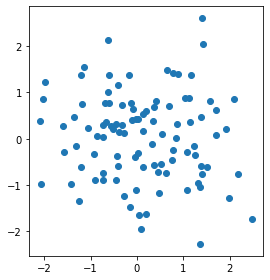

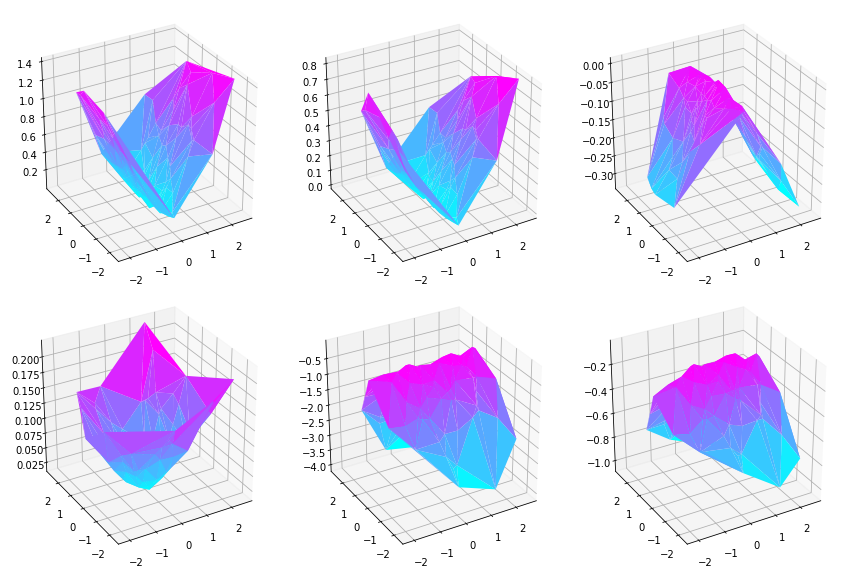

In [52]:
plt.figure('quantization_parameter_evolution2_points',figsize=(4,4))
ax1=plt.subplot(1,1,1)
plt.scatter(parameter[:,0],parameter[:,1])
ax1.set_aspect(1.)
plt.tight_layout()
plt.savefig(case_label+'quantization_parameter_evolution2_points'+str(K)+'.pdf')

if(False):#2D plot, do not use it
  plt.figure('quantization_parameter_evolution2_values',figsize=(4*2,4))
  ax2=plt.subplot(1,2,1)
  for ii in range(K):
    ax2.plot(list(range(nb_param)),quantization_cv[:,0,ii],linewidth=4)
  #ax2.set_aspect(1.)

  ax3=plt.subplot(1,2,2)
  for ii in range(K):
    ax3.plot(list(range(nb_param)),quantization_cv[:,1,ii],linewidth=4)
  #ax3.set_aspect(1.)
  plt.tight_layout()
  plt.savefig(case_label+'quantization_parameter_evolution2_values'+str(K)+'.pdf')

if(False):#will draw 2 surface 3D plots
  plt.figure('quantization_parameter_evolution2_values_3D',figsize=(4*2,4))
  ax2=plt.subplot(1,2,1)
  for ii in range(K):
    ax2.plot(list(range(nb_param)),quantization_cv[:,0,ii],linewidth=4)
  #ax2.set_aspect(1.)

  ax3=plt.subplot(1,2,2)
  for ii in range(K):
    ax3.plot(list(range(nb_param)),quantization_cv[:,1,ii],linewidth=4)
  #ax3.set_aspect(1.)
  plt.tight_layout()
  plt.savefig(case_label+'quantization_parameter_evolution2_values'+str(K)+'.pdf')

if(True):  
  plotK=3#only plot three examples
  # Creating figure
  fig = plt.figure("surface",figsize=(4*plotK,4*2))
  count=0
  for jj in range(2):
    for ii in range(plotK):
      count +=1
      ax = plt.subplot(2,plotK,count,projection ='3d')
      ax.plot_trisurf(parameter[:,0],parameter[:,1],quantization_cv[:,jj,ii],cmap='cool');
      ax.view_init(30, -120)
  #show plot
  plt.tight_layout()
  plt.savefig(case_label+'quantization_parameter_evolution2_surfaces'+str(K)+'.pdf')
  plt.show()